# Building Bonsai BDT for Online Triggering

* Step 1 : Pull out features for classification.  These include energy deposit on wire, energy deposit of left neighbour, energy deposit of right neighbour, and layer id (radial distance).
* Step 2 : Bin these features into 11 bins, 10 with deposits, one with no deposits
* Step 3 : Train the GBDT to recognize hit wires based on these binned energy features and layer_id
* Step 4 : Build a look up table of dimention [11,11,11,18], so it has an entry for each possible combination of features
* Step 5 : Fill the table with the output of the wire GBDT
* Step 6 : Define layer features based on this output
* Step 7 : Pass layer features through event GBDT
* Step 8 : Determine signal or background based on this output

In [260]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [261]:
from hits import AllHits, ResampledHits, OnlyBackgroundHits
hits = AllHits('../data/signal_TDR.root')

In [6]:
from tracking import Hough
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [7]:
def bin_energies(deposits, edges=[5,15,20,25,30,35], zero_bin=True):
    deposits_f = deposits.flatten()
    edges = numpy.percentile(deposits_f[deposits_f > 0],edges)
    new_deps = numpy.searchsorted(edges,deposits)
    if zero_bin:
        new_deps = new_deps + 1
        new_deps[deposits == 0] = 0
    return new_deps

In [8]:
def binary_binning(deposits, threshold=0.000005):
    new_deps = deposits < threshold
    new_deps[deposits == 0] = 0
    return new_deps.astype(int)

### Collect (Raw) Wire Features 

In [9]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
# Flatten before binning 
deposits_f = deposits.flatten()

## Bin the deposits data
#new_deps = bin_energies(deposits, e_bin_edges)

## Binary Binning
new_deps = binary_binning(deposits)

# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_layers for i in range(hits.n_events))

### Define Left/Right Neighbours

In [10]:
right_neighs = numpy.array([hits.cydet.shift_wire(wire, 1) for wire in range(hits.cydet.n_points)])
left_neighs = numpy.array([hits.cydet.shift_wire(wire, -1) for wire in range(hits.cydet.n_points)])

### Define Features

In [18]:
from collections import OrderedDict
features = OrderedDict()
# Features
features['Layer_ID'] = layer_id

## Unbinned deposits
# Wire deposits scaled by 1000 to avoid small numbers for GBDT
features['Deposits'] = deposits * 1000
# LR-Neighbour Features
features['R_Deposits'] = (deposits * 1000)[:, right_neighs]
features['L_Deposits'] = (deposits * 1000)[:, left_neighs]


# Wire features
features['Binned_Deposits'] = new_deps
# LR-Neighbour Features
features['Binned_R_Deposits'] = new_deps[:, right_neighs]
features['Binned_L_Deposits'] = new_deps[:, left_neighs]

# Truth values
features['Labels'] = labels

In [19]:
print numpy.unique(new_deps)

[0 1]


In [20]:
# Name train features as all featurs except label
train_features = features.keys()[:-1]
# Name data as all features stacked in 3D array
data = numpy.dstack(features.values())
# Count the number of features
n_feats = data.shape[-1]
print data.shape

(3445, 4482, 8)


## Train/test splitting 

In [21]:
from sklearn.cross_validation import train_test_split
train_events, test_events = train_test_split(range(len(labels)), train_size=0.15, test_size=0.25)

## Features for Wire GBDT

In [22]:
import pandas
# Define a small portion of the data to be used as a 0th order guess of if the wire is a signal or not
wire_trn_data = data[train_events].reshape(-1, n_feats)
wire_trn_data = pandas.DataFrame(data=wire_trn_data, columns=features.keys())
wire_tst_data = data[test_events].reshape(-1, n_feats)
wire_tst_data = pandas.DataFrame(data=wire_tst_data, columns=features.keys())

In [23]:
# Purge cells with no hits out
wire_trn_data = wire_trn_data[wire_trn_data['Labels'] != 0]
wire_tst_data = wire_tst_data[wire_tst_data['Labels'] != 0]

# Define signal hit as 1, background hit as 0
wire_trn_data['Labels'] = 2 - wire_trn_data['Labels']
wire_tst_data['Labels'] = 2 - wire_tst_data['Labels']

## Prepare the GBDT

In [24]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [25]:
factory = ClassifiersFactory()

train_features_org = ['Deposits','L_Deposits','R_Deposits', 'Layer_ID']
train_features_bin = ['Binned_Deposits','Binned_L_Deposits','Binned_R_Deposits', 'Layer_ID']


# Define GBDT over unbinned wire features
gb_wire_features_org = SklearnClassifier(GradientBoostingClassifier(n_estimators=400), 
                                    features=train_features_org)
# Define GBDT over binned wire features
gb_wire_features_bin = SklearnClassifier(GradientBoostingClassifier(n_estimators=400), 
                                    features=train_features_bin)
# Define GBDT over energy deposit
gb_energy = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=['Deposits'])


factory.add_classifier('Original Wire Features', gb_wire_features_org)
factory.add_classifier('Binned Wire Features', gb_wire_features_bin)
factory.add_classifier('Energy Deposit Only', gb_energy)

#only_binned = ClassifiersFactory()
#only_binned.add_classifier('Binned Wire Features', gb_wire_features_bin)

In [26]:
# Train the classifier
factory.fit(wire_trn_data, wire_trn_data['Labels'])
#only_binned.fit(wire_trn_data, wire_trn_data['Labels'])
pass

model Original Wire Features was trained in 160.35 seconds
model Binned Wire Features was trained in 82.56 seconds
model Energy Deposit Only was trained in 20.89 seconds
Totally spent 263.81 seconds on training


In [27]:
# Test the classifier
wire_predictions = factory.test_on(wire_tst_data, wire_tst_data['Labels'])
#binned_predictions = only_binned.test_on(wire_tst_data, wire_tst_data['Labels'])

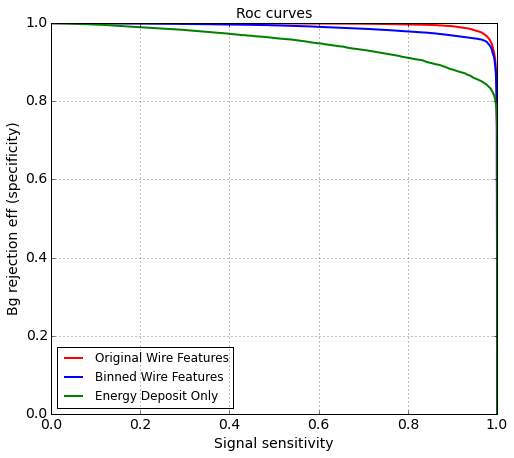

In [28]:
figsize(8,7)
roc = wire_predictions.roc()
roc.plot()
show()

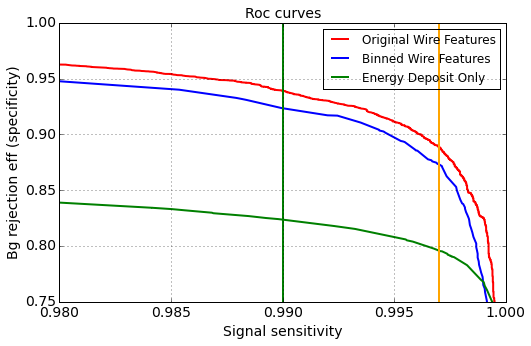

In [29]:
figsize(8,5)
roc.plot(xlim=[0.98,1.], ylim=[0.75,1.])
plt.plot([.99, .99], [0.75, 1.], 'k-', lw=2,  c='g' )
plt.plot([.997, .997], [0.75, 1.], 'k-', lw=2,c='orange')

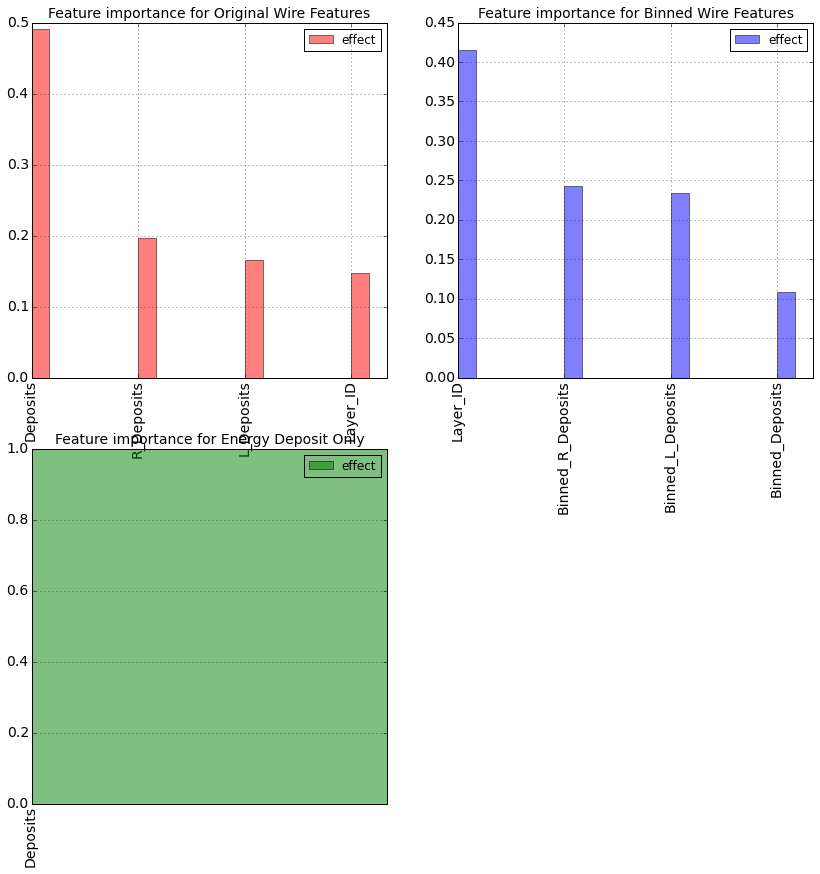

In [30]:
wire_predictions.feature_importance().plot(figsize=[14, 14])

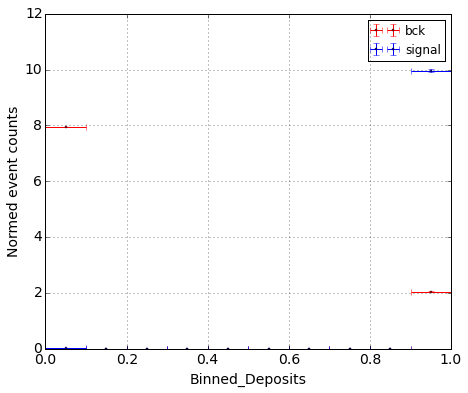

In [31]:
dep = wire_predictions.features_pdf(features=['Binned_Deposits'], bins=10)
dep.plot()

In [32]:
# Take only the all features GBDT from here on out
binned_gbdt = factory['Binned Wire Features']

# Apply to the final training data
binned_gbdt_out = binned_gbdt.predict_proba(wire_tst_data)

# Take only the signal probability
binned_gbdt_out = binned_gbdt_out[:,1]

print len(numpy.unique(binned_gbdt_out))

# Remind outselves of the labels
binned_labels = wire_tst_data['Labels']

144


In [33]:
print shape(wire_tst_data)

(595373, 8)


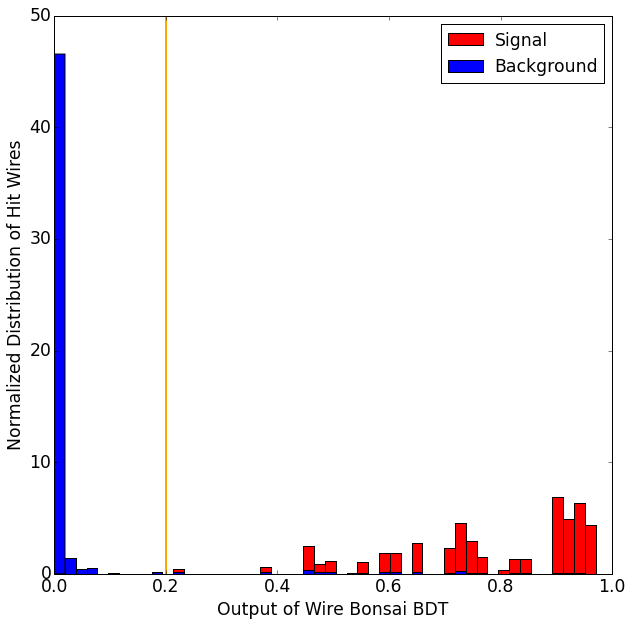

In [34]:
# Plot the distribution
sig = numpy.where(binned_labels == 1) 
bkg = numpy.where(binned_labels == 0) 

figsize(10,10)
plt.xticks(fontsize ='xx-large')
plt.yticks(fontsize ='xx-large') 
plt.xlabel('Output of Wire Bonsai BDT', fontsize='xx-large')
plt.ylabel('Normalized Distribution of Hit Wires', fontsize='xx-large')

plt.hist(binned_gbdt_out[sig], normed=True, bins=50, label='Signal')
plt.hist(binned_gbdt_out[bkg], normed=True, bins=50, label='Background')
plt.plot([0.2, 0.2], [0, 50], 'k-', lw=2,c='orange')

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(fontsize='xx-large')

### Build Bonsai BDT

In [35]:
# Check for the binning used in the bonsai BDT
n_bins = len(numpy.unique(new_deps))
n_layers = len(numpy.unique(layer_id))
# Get the GBDT we want
binned_gbdt = factory['Binned Wire Features']

In [36]:
# Build a numpy array to hold all possible combinations
combinations = numpy.zeros((n_bins*n_bins*n_bins*n_layers,4))
n = 0
print n_layers

# Fill the combinations
for wire in range(n_bins):
    for left in range(n_bins):
        for right in range(n_bins):
            for layer in range(n_layers): 
                combinations[n,:] = wire, left, right, layer
                n += 1
# Make it a data frame with the correct labels
combinations = pandas.DataFrame(data=combinations,columns=['Binned_Deposits','Binned_L_Deposits',\
                                                           'Binned_R_Deposits','Layer_ID'])

18


In [50]:
# Check the shapes and indecies
print combinations.shape
print combinations.keys()
# Get the desired outputs for these combinations
binned_gbdt_all = binned_gbdt.predict_proba(combinations)[:,1]

(144, 4)
Index([u'Binned_Deposits', u'Binned_L_Deposits', u'Binned_R_Deposits', u'Layer_ID'], dtype='object')


In [52]:
# Reshape into a Bonsai BDT
print binned_gbdt_all.shape
bonsai_gbdt = binned_gbdt_all.reshape(n_bins,n_bins,n_bins,-1)
# Set no hits equal to zero chance of signal
## CONTROVERCIAL MOVE
bonsai_gbdt[0,:,:,:] = 0

(144,)


In [53]:
# Test the output of the bonsai BDT
event = 10000
dummy_event = wire_trn_data[event:event+1]
print dummy_event
this_event = dummy_event.values[0]
print binned_gbdt.predict_proba(dummy_event)[:,1][0]
print bonsai_gbdt[round(this_event[4]), round(this_event[6]), round(this_event[5]), round(this_event[0])]

       Layer_ID  Deposits  R_Deposits  L_Deposits  Binned_Deposits  \
62656        17  0.428453    0.013778    0.020741                0   

       Binned_R_Deposits  Binned_L_Deposits  Labels  
62656                  0                  0       0  
6.38774803394e-08
0.0


## Recover Layer Level Features

In [179]:
signal = ResampledHits(occupancy=0.30)
background = OnlyBackgroundHits(occupancy=0.30, n_events=2000)

In [180]:
#signal = AllHits('../data/online_sig_and_noise.root')
#background = AllHits('../data/online_noise.root')
used_signal = 2000
combined_events = used_signal + background.n_events
print combined_events

4000


In [181]:
event_features = OrderedDict()

# Energy deposits
sig_deposits = numpy.vstack(signal.get_energy_deposits(i) for i in range(used_signal))
bkg_deposits = numpy.vstack(background.get_energy_deposits(i) for i in range(background.n_events))
evt_deposits = numpy.vstack([sig_deposits,bkg_deposits])
print shape(evt_deposits)

(4000, 4482)


In [182]:
# Layer ID of hit wires
evt_layer_id = numpy.vstack(signal.cydet.point_layers for i in range(combined_events))

# Truth labels
evt_labels = numpy.append(numpy.ones(used_signal), numpy.zeros(background.n_events)).transpose()

# Bin the energies
#evt_new_deps = bin_energies(evt_deposits)

## Binary Binning
evt_new_deps = binary_binning(evt_deposits)

# Get the left and right neighbours 
evt_new_deps_r =  evt_new_deps[:, right_neighs]
evt_new_deps_l =  evt_new_deps[:, left_neighs]

print evt_deposits.shape

(4000, 4482)


In [183]:
# Get Bonsai Output
## Simple sum
evt_bonsai_out = numpy.vstack( bonsai_gbdt[evt_new_deps[i,:],\
                                           evt_new_deps_l[i,:],\
                                           evt_new_deps_r[i,:],\
                                           evt_layer_id[i,:]] for i in range(combined_events))
## Sum of squares
#evt_bonsai_out = numpy.square(evt_bonsai_out)
## Cut the values
#evt_bonsai_out = numpy.vstack( evt_bonsai_out[i,:] > 0.2 for i in range(combined_events))

In [184]:
def classify_layers(evt):
    sum_by_layer = [sum(evt_bonsai_out[evt,f_wre:f_wre+n_wres]) for f_wre, n_wres\
                            in zip(signal.cydet.first_point,signal.cydet.n_by_layer)]
    return numpy.array(sum_by_layer)

In [240]:
evt_layer_out = numpy.vstack( classify_layers(i) for i in range(combined_events))
evt_layer_out = numpy.vstack( np.divide(classify_layers(i), hits.cydet.n_points)\
                              for i in range(combined_events))

print evt_layer_out.shape

(4000, 18)


## Prepare GBDT Over Layer Features

In [241]:
layer_features = OrderedDict()

# First order is to just add each layer value as a feature.  This is upper limit of performance
for lay in range(n_layers):
    layer_features["Layer_"+str(lay)] = evt_layer_out[:,lay]

max_layer = numpy.hstack( [ np.where(evt_layer_out[i,:] == np.sort(evt_layer_out[i,:])[-1])[0][0]\
                                                      for i in range(combined_events)])
max_value = numpy.hstack( np.sort(evt_layer_out[i,:])[-1] for i in range(combined_events) )

n_max_layer = numpy.hstack( [ np.where(evt_layer_out[i,:] == np.sort(evt_layer_out[i,:])[-2])[0][0]\
                                                      for i in range(combined_events)])
n_max_value = numpy.hstack( [np.sort(evt_layer_out[i,:])[-2] for i in range(combined_events)])

nn_max_layer = numpy.hstack( [ np.where(evt_layer_out[i,:] == np.sort(evt_layer_out[i,:])[-3])[0][0]\
                                                      for i in range(combined_events)])
nn_max_value = numpy.hstack([np.sort(evt_layer_out[i,:])[-3] for i in range(combined_events)])

layer_features["Max_Layer"] = max_layer
layer_features["Max_Value"] = max_value
layer_features["N_Max_Layer"] = n_max_layer
layer_features["N_Max_Value"] = n_max_value
layer_features["NN_Max_Layer"] = nn_max_layer
layer_features["NN_Max_Value"] = nn_max_value

# Truth labels for each event
layer_features["Labels"] = evt_labels

In [242]:
# Name train features as all featurs except label
evt_train_features = layer_features.keys()[:-1]
# Name data as all features stacked in 3D array
evt_data = numpy.vstack(layer_features.values()).transpose()

# Count the number of features
n_evt_feats = evt_data.shape[-1]

In [243]:
evt_train_events, evt_test_events = train_test_split(range(len(evt_labels)), train_size=0.50, test_size=0.40)
evt_trn_data = pandas.DataFrame(data=evt_data[evt_train_events], columns=layer_features.keys())
evt_tst_data = pandas.DataFrame(data=evt_data[evt_test_events], columns=layer_features.keys())

In [244]:
evt_factory = ClassifiersFactory()

evt_trn_feats_full = evt_train_features
evt_all_layers = evt_train_features[:10] + evt_train_features[n_layers:]
evt_special_layers = evt_train_features[n_layers:]

# Define GBDT over all layer sums
gb_full_layer_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=800), 
                                    features=evt_trn_feats_full)
gb_sum_layer_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=800), 
                                    features=evt_all_layers)
gb_special_layer_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=800), 
                                    features=evt_special_layers)
 

evt_factory.add_classifier('All Features', gb_full_layer_features)
evt_factory.add_classifier('Sum Features', gb_sum_layer_features)
evt_factory.add_classifier('Special Features', gb_special_layer_features)

#only_binned = ClassifiersFactory()
#only_binned.add_classifier('Binned Wire Features', gb_wire_features_bin)

In [245]:
# Train the classifier
evt_factory.fit(evt_trn_data, evt_trn_data['Labels'])
#only_binned.fit(wire_trn_data, wire_trn_data['Labels'])
pass

model All Features was trained in 4.04 seconds
model Sum Features was trained in 3.21 seconds
model Special Features was trained in 1.59 seconds
Totally spent 8.83 seconds on training


In [246]:
# Test the classifier
evt_predictions = evt_factory.test_on(evt_tst_data, evt_tst_data['Labels'])
#binned_predictions = only_binned.test_on(wire_tst_data, wire_tst_data['Labels'])

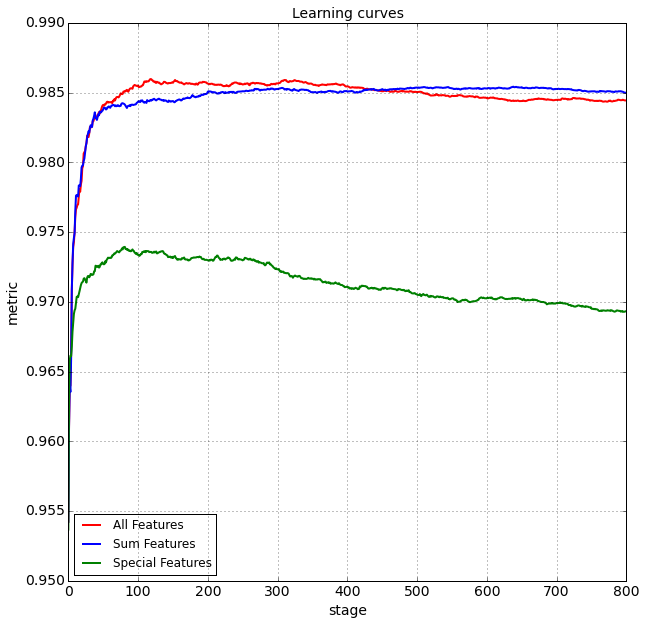

In [247]:
# Look at learning curves
figsize(10,10)
evt_predictions.learning_curve(RocAuc(), steps=1)

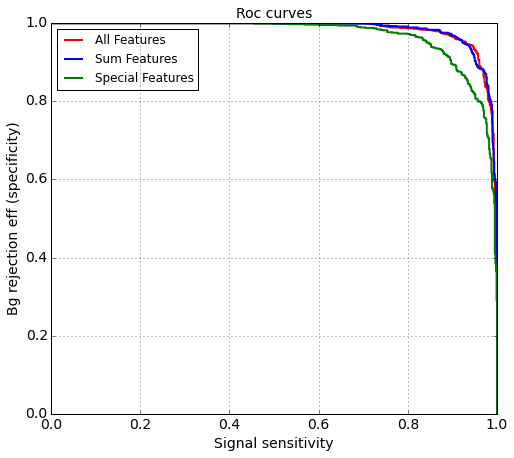

In [248]:
figsize(8,7)
roc = evt_predictions.roc()
roc.plot()
show()

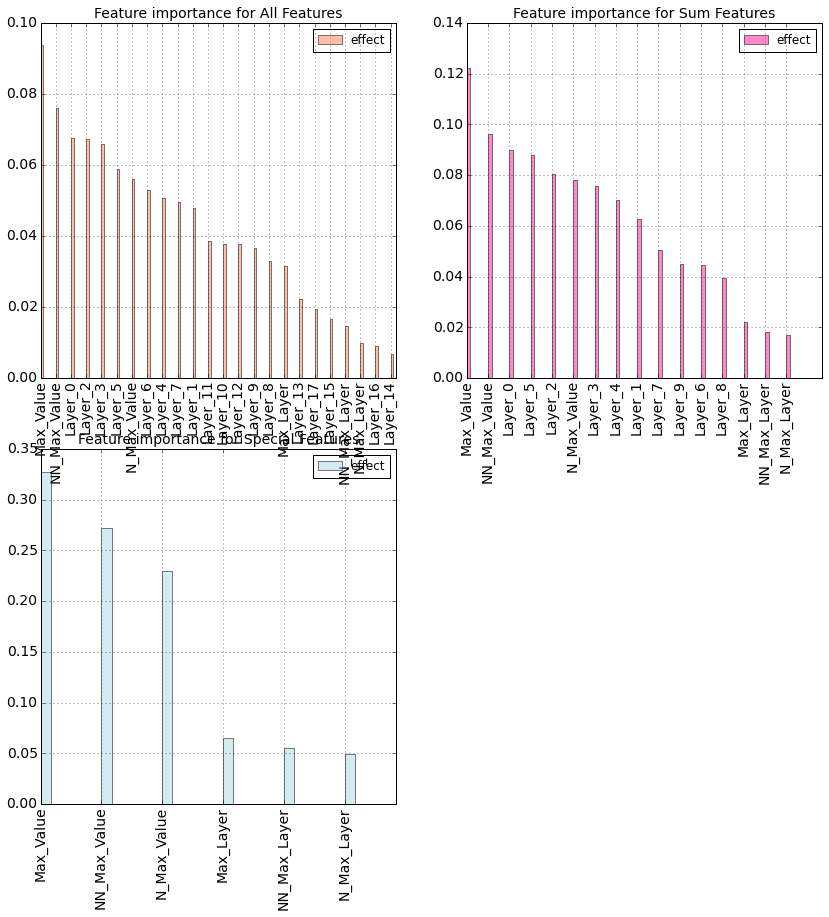

In [249]:
evt_predictions.feature_importance().plot(figsize=[14, 14])

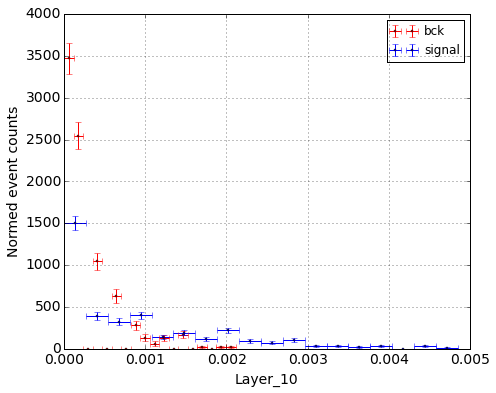

In [259]:
dep = evt_predictions.features_pdf(features=['Layer_10'], bins=18)
dep.plot()